In [561]:
import pandas as pd 
import numpy as np
import scipy.stats as ss

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from pprint import pprint

# set some styling defaults for matplotlib
plt.style.use("seaborn-talk")
mpl.rcParams["figure.dpi"] = 90  # change this to set apparent figure size
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.frameon"] = False

# set decimal precision to 3 dec. places
%precision 3

'%.3f'

# II: Theory and practice

**sli.do** https://app.sli.do/event/qz3PTe61RKpcryL6xGCDUS

## Outcomes

You will understand:

* What a Bayesian is.
* The idea of a data generating process;
* The relation of models and parameters;
* What uncertainty is, where it comes from, and why it is important;
* What probability is and how it represents uncertainty;
* The distinction between prediction and inference and the relation to forward and inverse probability.
* A high-speed review of basic probability theory through code: 
    * axioms of probability
    * mass functions, distributions, random variables
    * likelihood and sampling
    * joint, marginal, conditional, Bayes' rule
    * entropy, divergence
* Major classes of Bayesian inference algorithms

### Survey results
<img src="imgs/survey_prob.png">

----


## What is a Bayesian [I]?

### Poll

What does being a Bayesian mean to you, right now?

---

<img src="imgs/facets.png" width="30%">

A Bayesian is someone who:

* Is happy to live without truth;
* Reasons from belief to belief, guided by evidence;
* Thinks backwards by thinking forwards.

### Without truth
We might be used to computations that deal in absolute truths, but these aren't that useful for modelling. Very few processes are sufficiently stable and sufficiently well-understood that
they can be precisely modelled without uncertainty. Only being capable of dealing in absolute truths is exceedingly limiting; it breeds fragility and irrationality. 

### Belief to belief
A Bayesian computation does not result in a change of *state*, but a change of beliefs. This originates from some original beliefs and is then adjusted to be compatible with evidence that has been observed. This evidence typically concentrates belief on a tighter set of possible configurations. 

### Forwards, not back
Bayesian modelling involves first modelling *what we might observe given a hypothesis* and not *what hypothesis to choose given an observation*. This is a very important distinction, and makes it trivial to combine evidence from multiple sources.


# Models
Let's get back to computational interaction. A tenet of the approach is that it puts models *first*. Every model in computational interaction will be a bit of code that is executed in order to gain insight into an interaction phenomena that we cannot directly access. Not all things that are called models are equivalent, however. We need to think about the characteristics that of models of interaction: are some better than others?

## On the virtues of models
Given two models that model some interaction phenomena equally well, we'd prefer the model that:

* is easily implemented computationally and fits with software engineering practices;
* is conveniently parameterised, with *interpretable* parameters;
* is generative, and expressed in terms of generating synthetic observations;
* is capable of propagating uncertainty correctly.

## Data generating processes
 We need *models* to do *computational interaction*, and they need to be *executable*. We'd further like them to be *generative*. That implies code that simulates or emulates some part of an interactive system -- a **forward model** that transforms unknown states into the observable quantities they imply. At the heart of Bayesian modelling we have the idea of a **data generating process**, a process which we believe is generating data we observe. We implement this as an algorithm
which generates synthetic observations. 

> This is just a function!


Every application of Bayesian ideas starts with the data generating process: write down code that will spit out plausible simulations, given some configurable parameters.



### A very simple example
Let's model how tall someone is.

In [729]:
def how_tall_cm_1():
    return 180.0

In [730]:
how_tall_cm_1()

180.000

That isn't a very inspiring model, but it is a computational model that we can execute. A better model would be parametric (i.e. takes parameters).

### Parameters

These are just the things that we can vary to change the result (i.e. parameters we pass in to the function)

In [731]:
def how_tall_cm_2(gender):
    if gender=="male":
        return 175
    if gender=="female":
        return 162            

In [733]:
how_tall_cm_2("male")

175

Or multiple parameters:

In [734]:
def how_tall_cm_3(gender, age):
    if gender == "male":
        return 85 + min(age, 16) * 5.63
    if gender=="female":
        return 80 + min(age, 16) * 5.13

In [737]:
how_tall_cm_3("female", 24)

162.080


### Higher-level parameters

We can have higher-level parameters, where the model includes parameters that determine other parameters or the relationships between them. Sometimes we will have a mixture of *observed* values and *latent* (hidden) parameters; but this poses no problem in modelling. 

We often write things like $$y = f(x;\theta)$$ to mean a function that produces simulated observations $y$, taking *observed* inputs $x$ and latent parameters $\theta$.

In [738]:
### Latent parameters
### Now the "magic constants" are passed in as parameters
def how_tall_cm_latent(gender, *, mean_height=160, m_f_difference=6.5):
    if gender=="male":
        return mean_height + m_f_difference
    if gender=="female":
        return mean_height - m_f_difference  
    

In [739]:
how_tall_cm_latent("male", m_f_difference=10.5)

170.500


## Uncertainty

>    All theorems are true.  
>    All models are wrong.  
>    And all data are inaccurate.  
>    What are we to do?  
>    We must be sure to remain uncertain. 

-- *[Leonard A. Smith, Proc. International School of Physics ``Enrico Fermi", (1997)](http://www2.maths.ox.ac.uk/~lenny/fermi96_main_abs.html)* 

<img src="imgs/uncertainty_forecast.png">

### What is uncertainty and where does it come from?
Uncertainty exists in all systems that make contact with the real world. The physical world is not the domain of absolute logical truth, and the human social world is even less so. This is especially true when we project into the future (prediction, or forecasting), but even when reasoning about the present or the past, we must account for and be aware of the uncertainty involved.

In interaction, we have, in the simplest case, two parties, or agents: 

* a brain, embedded in a human, embedded in a physical world
* and software, embedded in computer hardware, embedded in the same physical world. 

Each of these "agents" has uncertainty about the other. Some of this uncertainty is due to the world that separates them (e.g. noise in the motor system). Some of it is because they do not (yet) have knowledge of each others' states.

#### Epistemic, aleatoric and approximation

We can separate out some *types* of uncertainty:

* **Epistemic uncertainty** is uncertainty about what we know (hence epistemic) arising from the limitations of our knowledge (as encoded by a model).  If I've only ever met one person, my epistemic uncertainty about the height of people is likely to be large -- I don't *know* how tall people are.
* **Aleatoric uncertainty** is that which arises from (presumed) randomness in the world. If I toss a coin, my uncertainty about which side lands face up is aleatoric. This type of uncertainty cannot be resolved by better modelling, more data, etc.; it is irreducible. Even if I have an excellent model of people's heights, any given person's height won't be precisely predicted by that model.
* **Approximation uncertainty** arises from the limitations of computation to approximate inference. In general, Bayesian methods cannot be applied exactly, and so the results are subject to additional uncertainty.

#### The wonder-goop
Uncertainty is what makes a model *statistical*, and it can be used to model real randomness in phenomena. But we often have to build simple, tractable models that we know are *bad* models of the real world -- they simply can't represent the true complexity of an interactive system. We can just add uncertainty as "goop" to soak up the variation between the truth and the model; we *pretend* that there is randomness to mask the misalignment. If done correctly, our inferences are still correct, and *represent* the degree to which they have misfit reality.

Uncertainty isn't *bad* -- it simply exists -- but ignoring it is demonstrably harmful.

Text(0, 0.5, 'y')

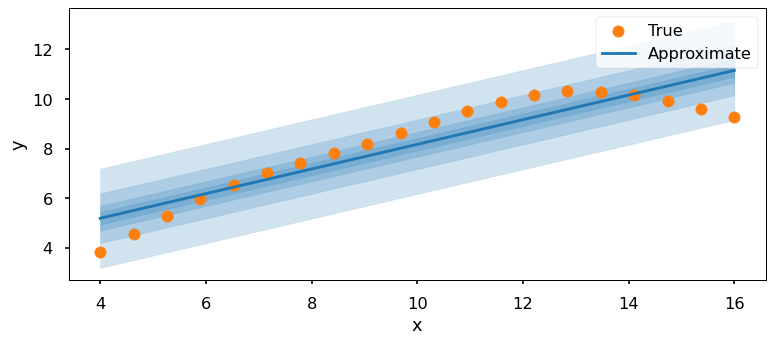

In [740]:

# a function that is not a line
def f(x):
    return x + np.cos(x) * 0.2 - 0.0001 * x ** 4

# a line does not fit
# but a line + noise does
# even though the "noise" is not random
x = np.linspace(4, 16, 20)    
y = f(x)
p = np.polyfit(x, y, 1)
y_prime = np.polyval(p, x)

# plot the graph
fig, ax = plt.subplots()
err = 1
for l in [0.25, 0.5, 1, 2]:
    ax.fill_between(x, y_prime-l*err, y_prime+l*err, color='C0', alpha=0.2)

ax.scatter(x, y, label='True', c='C1')
ax.plot(x, y_prime, label='Approximate')
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")



### Stochastic results: sampling

The simple models of height we wrote above are purely deterministic. In interaction, it's rare to have a model that can precisely predict an outcome, even if the parameters are known: models aren't exact representations of reality [epistemic], and reality isn't predictable anyway [aleatoric].

A *statistical* data generating process would model the process with randomness, to reflect that we are drawing a (random) sample from a larger postulated population of possibilities. In practice, this just means we add random number generators to our function.

In [745]:
### Stochastic model
### Implements aleatoric uncertainty
def how_tall_cm_4(gender):
    if gender=="male":
        return np.random.normal(175, 10)
    if gender=="female":
        return np.random.normal(162, 7)

In [746]:
how_tall_cm_4("female")

164.644

In [747]:
how_tall_cm_4("female")

167.059

Text(0, 0.5, 'Count')

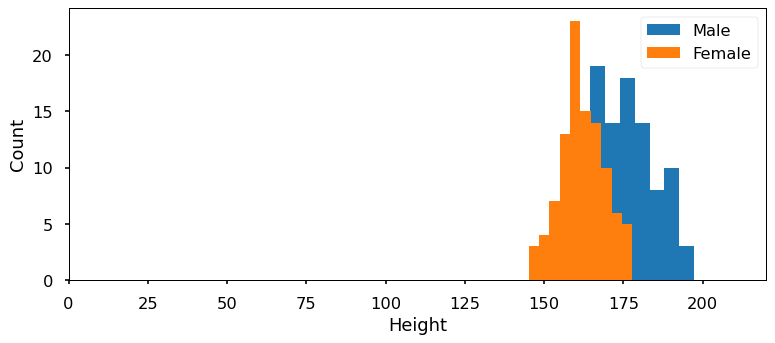

In [748]:
# show a a histogram
fig, ax = plt.subplots()
ax.hist([how_tall_cm_4("male") for i in range(100)], label="Male")
ax.hist([how_tall_cm_4("female") for i in range(100)], label="Female")
ax.legend()
ax.set_xlim(0, 220)
ax.set_xlabel("Height")
ax.set_ylabel("Count")

### Likelihood: the backdoor key

To do Bayesian modelling, we will need one more thing in our data generating processes: a measure of how "likely" an observation is to have been generated by the simulation. We can see this as a measure of compatibility of a possible observation with the particular parameters of a model.
    
> Note that we can sometimes work around this requirement  and use pure simulation models, using **approximate Bayesian computation (ABC)** -- but this tends to be quite inefficient. Still, the ABC approach, means we can use any model, without this likelihood function. 

This special feature will be the key to letting us *invert* our simulator, and work out how it is configured by feeding it possible data it might have generated.

For now, we'll assume we just get a number telling us how good a fit an observation is given some parameters; the lower the number, the worse the fit.

In [756]:
### Likelihood: this is a function of data
### There's no randomness here!
def how_tall_cm_lik(gender, observed_height):    
    if gender=="male":
        return ss.norm(175, 8).logpdf(observed_height)
    if gender=="female":
        return ss.norm(162, 7).logpdf(observed_height)
    
print("male, 175cm tall", how_tall_cm_lik("male", 175))
print("female, 175cm tall", how_tall_cm_lik("female", 175))
print("male, 155cm tall", how_tall_cm_lik("male", 155))

male, 175cm tall -2.9983800748845084
female, 175cm tall -4.5893384781783535
male, 155cm tall -6.123380074884508


In [755]:
print("male 17.5cm tall", how_tall_cm_lik("male", 17.5))

male 17.5cm tall -196.79720819988452


Text(0, 0.5, 'Log-likelihood')

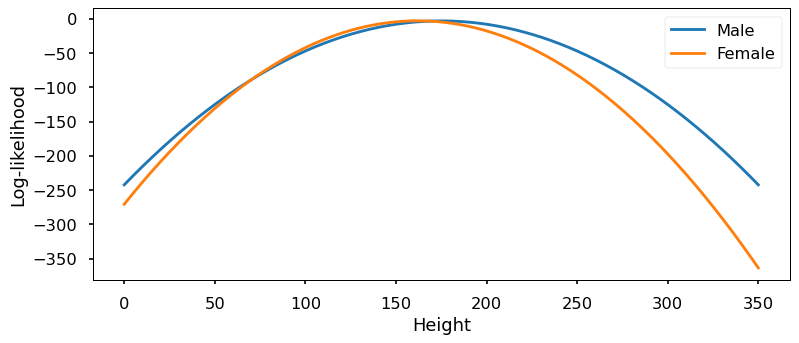

In [757]:
# show a plot of likelihood 
fig, ax = plt.subplots()
heights = np.linspace(0, 350, 350)
ax.plot(heights, [how_tall_cm_lik("male", h) for h in heights], label="Male")
ax.plot(heights, [how_tall_cm_lik("female", h) for h in heights], label="Female")

ax.legend()
ax.set_xlabel("Height")
ax.set_ylabel("Log-likelihood")

## Inversion

### A mysterious entity

We can imagine that the phenomena we are interested in (some interaction problem, say) is a mysterious entity who emits observable quantities (like the time taken to click on a menu item) but whose internal operation is inscrutable.

<img src="imgs/entity.png">

We can see the **data generating process** (our model) as a tame mysterious entity, who generates samples when simulating and can also judge the quality of observations (likelihood) when fed them.  The mysterious entity is controlled by parameters (dials) which adjust the simulation and its opinion of the quality of observations. What we want is to know *which* mysterious entity parameters are compatible with the true (but unseen) mysterious entity.

### Bayesian inversion

This is a problem of **inversion**; working out what was happening in the unobserved realm by deducing plausible behaviours compatible with the observations. Working out what age someone is given how tall they are is an inverse problem. Working out how tall they are given their age is a forward problem. In Bayesian modelling we use the **forward** model (the data generating process) as the key step to build our inversion model. 

> Other approaches solve inversion directly; for example we might build a machine learning model that predicts ages given heights by fitting a deep network to lots of paired `(age, height)` examples. We could then, at inference time, feed it a height and it would return an age. Critically, it would only return *one* age -- the best predicted age (as directed by the objective function used to train the network). This is very much **not** what we will do in the Bayesian models we will see later!

> * ML models: typically invert by optimising to find a single inverse function.
> * Bayesian models: invert by forming a distribution over inverse functions that are plausible, given observations.


## What is a Bayesian [II]?

A Bayesian:

* Builds generative models of the phenomena under consideration, that simulate plausible observations.
* Represents, preserves and manipulates uncertainty about unknown parameters. Uncertainty is **first-class**.
* Reasons about the unknown parameters that modulate the behaviour of those generative models.
* Uses *likelihood* to invert forward models.


# Probability


## Representations of uncertainty
We need to formalise the representation of uncertainty in our models. There are many possible ways to do this, but arguably only one good way: **probability**. Bayesians represent all uncertainty via probability, and describe the relative plausibility of states via **probability distributions**.

## What is probability?

A fraught philosophical question! See the references for debates on this topic. We'll make some uncontroversial statements, then an *interpretation* of probability. 

**Probability, as we shall use it, is simply an extension of ordinary logic to uncertain situations.**


### Basic facts

* We'll talk about **random variables**, written like $X$, that represent values we don't know. We do know their **probability distribution**, however.

* Probabilities are real numbers.

* A probability distribution associates a set of distinct *outcomes* (values) with probabilities. $P(X=x)$ meaning the probability that variable $X$ takes on outcome $x$.

In [758]:
# outcome : probability
coin_toss = {"heads": 0.5, "tails":0.5} 

robot_direction = {"fwd":0.6, "left":0.1, "right":0.0, "back":0.3}

dice_throw = {1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6, 6:1/6}

user_emotion = {"happy":0.1, "sad":0.2, "excited":0.05, "angry":0.1, 
                "confused":0.5, "crazed":0.05, "jubilant":0.05}

* Probabilities are non-negative and cannot exceed 1: $0 \leq P(A) \leq 1$ 
* The probability of all possible outcomes in a distribution sums to 1 exactly.

In [759]:
def proper(dist):
    ps = dist.values()
    assert all(0<=p<=1 for p in ps), "Probability is not in [0,1]"
    assert sum(ps) == 1.0, "Distribution does not sum to 1"
    return True

proper(coin_toss) # fine
proper(robot_direction) # fine

True

In [760]:
proper({"fwd":0.6, "left":0.1, "right":0.0, "back":0.5})

AssertionError: Distribution does not sum to 1

* We deal with sets of possible outcomes; the set of all outcomes in our "model" is the *sample space*.

In [761]:
def sample_space(dist):
    return list(dist.keys())

sample_space(robot_direction)

['fwd', 'left', 'right', 'back']

* An *event* is any set of outcomes. 

In [762]:
def p_of(event, dist):
    return sum(dist[outcome] for outcome in event)

p_of({"fwd", "back"}, robot_direction)

0.900

In [763]:
p_of({"happy", "sad", "crazed"}, user_emotion)

0.350

* If A and B are events $P(A \lor B) = P(A) + P(B) - P(A\land B)$ (sum rule; A and B are sets of outcomes)

In [764]:
def sum_rule(a, b, dist):
    p_a = p_of(a, dist)
    p_b = p_of(b, dist)
    p_ab = p_of(a.intersection(b), dist)
    return p_a + p_b - p_ab

sum_rule({"right", "back"}, {"back", "left"}, robot_direction)

0.400

In [765]:
p_of({"right", "back", "left"}, robot_direction) # just the same

0.400

* The probability of any set of events that cover all outcomes is therefore also 1.

* If A has probability $P(A)=P(X \in A)$, $P(¬A)=P(X \notin A)=1-P(A)$

* The probability of two *independent* events A and B is $P(A \land B) = P(A)P(B)$

In [766]:
def product_rule(a, b, dist_a, dist_b):
    return p_of(a, dist_a) * p_of(b, dist_b)

# what's the probability we go forward and we toss a coin that is heads?
product_rule({"fwd"}, {"heads"}, robot_direction, coin_toss)

0.300

* The probability of A *given we know that* an event B is true is written $P(A|B) = P(A \land B)/P(B)$

In [774]:
def condition(a, b, dist):
    a_and_b = p_of(a.intersection(b), dist)
    return a_and_b / p_of(b, dist)

# p(happy) given that I am happy, sad or confused
condition({"happy"}, {"happy", "sad", "confused"}, user_emotion)

0.125

* The probability of P(A|B) is **not** (in general) P(B|A)!

In [775]:
condition({"happy", "sad", "confused"}, {"happy"}, user_emotion)

1.000

#### Bayes' Rule (for the first time)

* $P(A|B) = P(B|A)P(A) / P(B)$ (Bayes' Rule)
* $P(B) = \sum_B P(B|A)P(A)$ 

---

### A simple probability distribution

I grab a single coin from my pocket. We assume they are all Euro coins. That's our space of possibilities -- the sample space.


* Regardless of what distribution of coins I have in my pocket, it cannot be less than impossible to pick a specific coin, nor more than certain.
* Probability of 0 means impossible* (caveats apply) and probability of 1 means certain.
* A probability distribution might map each coin (outcome) to a probability, a real number in [0,1]; for example:

<img src="imgs/coin.png">
    

In [776]:
coins = {0.01: 0.02,
         0.02 : 0.05,
         0.05 : 0.1,
         0.1 : 0.1,
         0.2 : 0.2, 
         0.5 : 0.2,
         1.0 : 0.3,
         2.0 : 0.03}

proper(coins)

True

* The probability of the coin being worth >50c is an *event*; perhaps $P(v>0.5)=P(v \in {1.0, 2.0})=0.33$
* A coin might be worth less than 10 cents $P(v<0.1) = P(v \in \{0.01, 0.02, 0.05\})$ 
* or being gold-coloured $P(v \in \{0.1, 0.2, 0.5\})$, or being 1 euro $P(v \in \{1.0\})$. 

These are all events.

In [777]:
possible_coins = sample_space(coins)
gold = {0.1, 0.2, 0.5}

print("P(v<0.1)", p_of([coin for coin in possible_coins if coin<0.1], coins))
print("P(v gold)", p_of(gold, coins))
print("P(v=1.0)", p_of({1.0}, coins))

P(v<0.1) 0.17
P(v gold) 0.5
P(v=1.0) 0.3


* Since we must draw exactly one coin, the event that includes all coins must have probability 1.0.

In [778]:
p_of(possible_coins, coins)

1.000

* The probability of a coin being less than 20c or more than *or* equal to 20c must also be 1.0, by the same logic (we cover every outcome exactly once). $P(v < 0.2 \lor v\geq 0.2) = P(v<0.2) + P(v \geq 0.2) = 1.0$

In [779]:
k = 0.2
(p_of([coin for coin in possible_coins if coin<k], coins) + p_of([coin for coin in possible_coins if coin>=k], coins))

1.000

* The probability of a coin being less than 50c or being gold-coloured is $P(v < 0.5 \lor v \in \{0.2, 0.5\}) = P(v<0.5) + P(v \in \{0.2, 0.5\}) - P(v<0.5 \land v \in \{0.2, 0.5\}) = P(v<0.5) + P(v \in \{0.2, 0.5\}) - P(v=0.5)$ -- we compensate for "double counting" the overlap

In [780]:
p_gold_or_50 = (p_of(gold, coins) 
                + p_of([coin for coin in coins if coin<0.5], coins) 
                - p_of([coin for coin in coins if coin<0.5 and coin in gold], coins))

print(p_gold_or_50)

0.6699999999999999


In [785]:
gold_or_50 = set(gold) | set([coin for coin in coins if coin<0.5])
print(p_of(gold_or_50, coins))

0.67


* The probability that I draw a coin that is gold coloured and it is a Spanish coin is $P(gold \land Spanish) = P(gold)P(Spanish)$, assuming these are independent (e.g. I don't specially collect gold-coloured Spanish euro coins)


In [37]:
coin_countries = {"Spanish":0.1, "French":0.1, "German":0.4, "Finnish":0.1, 
                 "Danish":0.0, "Irish":0.1, "Italian":0.1,  # Danes don't use Euros :)
                 "Czech":0.05, "Austrian":0.05}

In [38]:
product_rule(gold, {"Spanish"}, coins, coin_countries)

0.050


> * But the probability that I draw coin that is copper coloured and Finnish is **not** $P(copper)P(Finnish)$ (because 1c and 2c Finnish coins are very rare)



* The probability that I draw a gold coin given that the coin is less than a euro is $P(gold | v<1.0) = P(v \in \{0.1, 0.2, 0.5\}) / P(v \in \{0.01, 0.02, 0.05, 0.1, 0.2, 0.5\}) \approx 0.746...$


In [786]:
less_100 = {coin for coin in coins if coin<1.00}
p_of(gold & less_100, coins) / p_of(less_100, coins)

0.746


* **But note!** the probability that I draw a coin less than a euro given that it is gold is $P(v < 1.0 | gold) = P(v \in \{0.1, 0.2, 0.5\}) / P(v \in \{0.1, 0.2, 0.5\}) = 1.0$

In [787]:
p_of(gold, coins) / p_of(less_100 & gold, coins)

1.000


## Random variables and distributions

We'll use the following definitions of terms:

* A **random variable** $X$ is a variable whose value is not known, but whose possible values *are* known, and how likely those values are is also known. Probability theory allows us to manipulate random variables without having to assign them a specific value.
* A **probability distribution** $P(X=x)$ associates a random variables outcomes to probabilities. It encodes the plausibility of a variable's outcomes.
* A **probability mass function** $f_X(x)$ is a function that yields probabilities as a function of outcomes. This is just the dictionaries `{outcome: p}` we've already used.
* If we have uncountable outcomes (like real numbers), we instead use a **probability density function** $f_X(x)$, which just guarantees the rules above hold for dense subsets of the outcomes, even if they can't hold for individual outcomes.
    * Densities are not probabilities! They are non-negative, but can be greater than 1; the *integral* of a density over some domain *is* a probability. (e.g. $P(1\leq \text{age} \leq 2) = \int_1^2 f_X(\text{age}) dx$ over the interval [1, 2] of $\mathbb{R}$) 
    
### HCI random variables
A random variable could represent:

* whether or not a user is paying attention (discrete: binary), over the set of outcomes $\{\text{attending}, \text{ignoring}\}$; 
* the page of a document a user is reading $\{1,2,3,\dots\}$ (discrete); 
* the length of a user's arm (continuous), over the set of outcomes $\mathbb{R}$; 
* the gaze angle of a user's pupil with respect to a screen (continuous, multi-dimensional), over the set of outcomes $\mathbb{R}^2$. 
* a distribution over computer programs (discrete; infinite).

Each would have a distribution, defined by a probability mass or density function.

## Distributions
A **probability distribution** defines how likely different states of a random variable are. 

We can see $X$ as the the *experiment* and $x$ as the *outcome*, with a function mapping every possible outcome to a probability. 

> Be careful: these are *notional* experiments, not real ones. They might involve things that are in the past, or have no randomness. They are subjective experiments from the perspective of an agent. 

$$
P(A),\  \text{the probability of an event A}, \text{equivalent to} P(X \in A)\\
P(X=x),\  \text{the probability of random variable X taking on value x}\\
P(X),\  \text{shorthand for distribution of X }\\
$$

In [1]:
# be careful!
p_of({1, 2}, {1:0.5, 2:0.2, 3:0.1, 4:0.1}) # P(A), a number (from a set of outcomes)
p_of({1}, {1:0.5, 2:0.2, 3:0.1, 4:0.1})    # P(X=x), a number from an outcome
{1:0.5, 2:0.2, 3:0.1, 4:0.1}               # P(X), a distribution

NameError: name 'p_of' is not defined

## Philosophy

We will use the subjective Bayesian interpretation of probability. This has a simple statement but deep implications.

* Probability is a *degree of belief*.
* We express how strongly we believe something to be true with a probability. 
* We encode all beliefs as probability distributions. It's probabilities all the way down.
* We manipulate all beliefs via the rules above. This naturally includes all of classical logic, where P=0 is False and P=1 is True.
* We might expect that these probabilities would be *consistent* with observed relative frequencies of some random repeated process, but **that's not our definition of probability**. We do not invoke the mystical infinitely repeated identical experiments!
* It's completely fine to make statements like:
    * "the probability the next dice throw will be a four"
    * "the probability that it is raining right now"
    * "the probability that 2^10^10^10-1 is prime"
    * "the probability that the 2012 Olympics was in London" (think carefully about what the probability might be!)
    
* Because this form of probability theory is merely a logic of uncertain beliefs, we must always reason from some starting point. Rather than **axioms**, as in classical logic, we instead begin from **prior distributions**, associating beliefs to probabilities at the start of a reasoning process.

> We shall move from "what proportion of times will I draw a 50c coin from my pocket?" to "what do you *believe* about my having a 50c coin?"

### Random parameters
* We will associate probability distributions with the *parameters* of our data generating processes.
    * After all, we want to encode beliefs about what parameters could be reasonable.
    
* These distributions capture our *epistemic* uncertainty; they in turn may drive generation of random observations which have *aleatoric* uncertainty.
* This means that we will have distributions over processes, who in turn (usually) have distributions over possible observations.
* When we talk about Bayesian inference, we are talking about updating probability distributions over these parameters, given definite observations.

> In the age/height example at the top of the notebook, we'd put a probability distribution on the age *and* a probability distribution on the generated height. We'd then try and do inference, given a set of real, observed heights, to narrow down the likely ages.

<img src="imgs/random_parameters.drawio.png">

### Computer science

* Probability is a **universal language** for expressing uncertain states.
* Anything that "speaks probability" can be plugged into any other component that also does so.
    * (at least if we can map sample spaces onto each other)
* Probability is easy to encode in data structures for finite, discrete problems and the algorithms are simple
    * A hash table/dictionary or plain array can do most of the work.
* It is harder in continuous, multi-dimensional spaces or those with exotic topology.
    * Consequently, we will virtually always have to **approximate** probabilities in these situations.
    * And we will have to build and use approximation algorithms to do the hard work.

## Probability mass functions and probability density functions

We won't worry about the distinction too much in this brief intro. The main points are:

* A PDF is a function that maps outcomes to *densities*. These are not probabilities. They can be >1 (but must be positive).
* We can ask the probability that an outcome "lands" in any dense subset of a PDF (e.g. a contiguous range). This *is* a probability.
* It's often necessary to work with parametric functions for PDFs -- we end up manipulating the *parameters* computationally.
    * For example, a normal density has two parameters, $\mu$ and $\sigma^2$. From this we can evaluate a PDF function.
* It's often easier to think of the *cumulative distribution function*, the probability that an outcome lies below some threshold $x$.
    * This *is* a probability, and runs from 0 to 1 across the real numbers.

Text(0, 0.5, '$f_X$(height)')

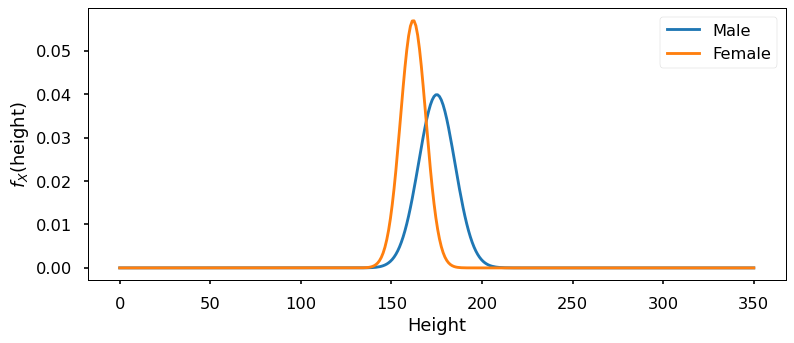

In [788]:
# show a PDF plot
fig, ax = plt.subplots()

def how_tall_cm_pdf(gender, observed_height):    
    if gender=="male":
        return ss.norm(175, 10).pdf(observed_height)
    if gender=="female":
        return ss.norm(162, 7).pdf(observed_height)
    
heights = np.linspace(0, 350, 350)
ax.plot(heights, [how_tall_cm_pdf("male", h) for h in heights], label="Male")
ax.plot(heights, [how_tall_cm_pdf("female", h) for h in heights], label="Female")

ax.legend()
ax.set_xlabel("Height")
ax.set_ylabel("$f_X$(height)")

Text(0, 0.5, 'P(X<height)')

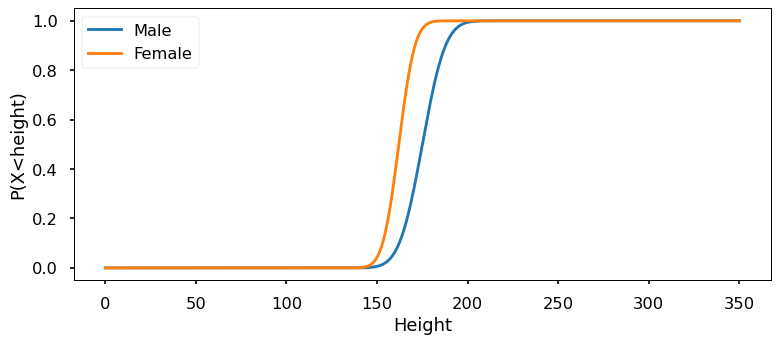

In [789]:
# show a CDF plot
fig, ax = plt.subplots()

def how_tall_cm_cdf(gender, observed_height):    
    if gender=="male":
        return ss.norm(175, 10).cdf(observed_height)
    if gender=="female":
        return ss.norm(162, 7).cdf(observed_height)
    
heights = np.linspace(0, 350, 350)
ax.plot(heights, [how_tall_cm_cdf("male", h) for h in heights], label="Male")
ax.plot(heights, [how_tall_cm_cdf("female", h) for h in heights], label="Female")

ax.legend()
ax.set_xlabel("Height")
ax.set_ylabel("P(X<height)")

### Inference

We seek a logical process to perform inference: the deduction of the hidden from the seen. We seek to do so under uncertainty, where we do not deal in absolutes of truth and falsity.

* Our primary tool is Bayes Rule. 
* The ability to do inference is derived from the ability to say: how likely is some unseen X given we saw Y?
    * "How likely is it that I am less than ten years old, given I am 120cm?"
        * I can see height; I can't see age.
    * We can answer that as:
        * It is the probability that we'd observe Y if X were true; multiplied by how likely we *already* believe X to be true; and normalised so that the probability for each possible X sums up to 1.
        
        
$$P(H|D) = \frac{P(D|H)P(H)}{P(D)} = \frac{P(D|H)P(D)}{\sum_H P(D|H)P(D)}$$

$$P(H|D) \propto P(D|H)P(D)$$ 

if all we care about is how *relatively* likely each possible $H$ is (not how *absolutely* likely it is)

* These parts have names:
    * `posterior = likelihood * prior / evidence`
    * **posterior** $P(H|D)$ The probability of beliefs about $H$ after having observed $D$
    * **likelihood** $P(D|H)$ How likely $D$ is to be observed under any possible hypothesised $H$
    * **prior** $P(H)$ How currently likely $D$ is before observing $H$
    * **evidence** $P(D)$ How likely $D$ is to be observed regardless of what hypothesis we make about $H$
    
> Note: we'll often use $\theta$ instead of H to imply that the hypothesis is a vector of parameters called $\theta$. We may also call $H$ $X$ and $D$ $Y$.

* The likelihood of D, written $L(D)$ is how likely $D$ is to be observed under a particular model. Often written $L(D|\theta)$ to mean "the likelihood of X under some specific parameters \theta".
    * Probabilities speak of the "future", of the relative propensity for unobserved outcomes to occur/be.
    * Likelihoods speak of the "past", of observed states. They are just a function of observations/data, and they tell us how likely observed outcomes are under some assumption (encoded by a model + parameters).
    * The likelihood is $L(x) = f_X(x)$, just the mass/density evaluated for a specific outcome. 

## Forward and inverse probability

* Questions of **forward probability** are likely to be familiar to you; they are the backbone of frequentist statistics, and they ask questions about the future outcomes given a probability distribution:
    * "What is the probability of drawing three 20c coins in a row" -> $P(D|H)$ -> FORWARD
    
* Questions of **inverse probability** require Bayesian inference, and they ask questions about the probability of the causes of outcomes already observed:
    * "What is the probability I only have gold coins, if I draw three 20c coins in a row" -> $P(H|D)$  -> INVERSE

In general, we want to do the inverse probability calculations not for one specific question (as above), but instead for an *entire* probability distribution:

* "What is the distribution over coins, given I draw three 20c coins in a row".

Note the difference between frequentist and Bayesian interpretations here:

* Frequentist statistics asks questions about infinite repeated trials, where we assume random outcomes but fixed (unknown) parameters.
* Bayesian statistics asks questions about random parameters, given fixed observations.

## What is a Bayesian? [III]

A **Bayesian**:

* Represents belief exclusively using probability distributions and conducts all computation about beliefs via the logic of probability.
* Reasons from hypotheses about the world to the evidence that those hypotheses would generate (via a data generating process).
* Updates belief using Bayes' Rule, combining a prior belief with observed evidence to deduce new beliefs.
* Infers conditional distributions -- posterior distributions -- over unseen parameters of the DGP.

Given a parameterised simulator that approximates the problem we are interested in, and some idea about what values these parameters could take on (expressed as a prior probability distribution) we can then use evidence to make a Bayesian update to concentrate a belief distribution on more likely parameter configurations --- a posterior probability distribution.

## Operations
Let's quickly review the operations on probability distributions we need in order to do Bayesian inference. We'll show each in code, with a simple example.

### A menu
Let's model a menu in an application. We might assume that there is some probability that different menu items will be selected by a user (we might have estimated this in various ways, but for now we'll just assume it is known).

<img src="imgs/menu.png" width="40%">

In [791]:
menu = {"new": 0.02,
         "settings" : 0.05,
         "revert" : 0.05,
         "save as" : 0.15,
         "new" : 0.2, 
         "open" : 0.22,
          "save":0.3,
         "rename" : 0.03}

proper(menu)

True

### Likelihood

Likelihood tells us for a fixed set of parameters, how likely an observation is. We need to define likelihood functions to define a Bayesian data generating process. We usually use the *log*-likelihood to avoid numerical issues; in particular if we take the product of many independent likelihoods, we can instead write the sum of the log-likelihoods.

In [792]:
def likelihood(outcome, pmf):
    return pmf[outcome]

def loglik(outcomes, pmf):
    # log-lik of a collection of independent outcomes
    return sum(np.log(pmf[outcome]) for outcome in outcomes)

In [793]:
likelihood("open", menu)

0.220

In [794]:
print(loglik(["open", "save", "open"], menu))
print(loglik(["new", "revert", "settings"], menu))

-4.232228269585487
-7.600902459542082


### Sampling
Sampling is the process of drawing definite realisations from a distribution. For discrete values, it is easy; for continuous values it may not be straightforward. 

This is the synthesis or simulation function.

In [795]:
def sample(pmf, n=1):
    return list(np.random.choice(list(pmf.keys()), p=list(pmf.values()), size=n))

In [796]:
sample(menu, 10)

['open',
 'save as',
 'revert',
 'save',
 'save',
 'save',
 'save as',
 'save',
 'open',
 'revert']

### Empirical distribution
We can estimate probability distributions from data. In the case of discrete sample spaces, we can estimate a PMF simply by counting the number of each outcomes observed, and normalising by the total number of observations overall. **This lets us learn PMFs from historical data by simple frequency estimation.**

This is the opposite of sampling -- estimating the PMF from samples.

In [799]:
from collections import Counter

def from_empirical(observations):
    c = Counter(observations)
    total = sum(c.values())
    return {outcome: count / total for outcome, count in c.items()}

In [800]:
user_trace = ["open", "save", "open", "save as", "open", "open", "new"]
from_empirical(user_trace)

{'open': 0.571, 'save': 0.143, 'save as': 0.143, 'new': 0.143}

#### Sampling <-> empirical distribution
If we estimate the empirical distribution from samples, we'll eventually recover the true PMF (if we had infinite samples, anyway).

In [804]:
print(from_empirical(sample(menu, 10)))

{'new': 0.2, 'save as': 0.2, 'open': 0.3, 'save': 0.3}


In [805]:
print(from_empirical(sample(menu, 100)))

{'save': 0.31, 'new': 0.18, 'open': 0.22, 'settings': 0.05, 'save as': 0.16, 'revert': 0.05, 'rename': 0.03}


In [806]:
print(from_empirical(sample(menu, 1000)))

{'new': 0.232, 'save as': 0.151, 'open': 0.193, 'settings': 0.054, 'save': 0.29, 'revert': 0.057, 'rename': 0.023}


In [807]:
print(from_empirical(sample(menu, 100_000)))

{'open': 0.22102, 'save as': 0.15097, 'rename': 0.03017, 'save': 0.29865, 'new': 0.19801, 'settings': 0.05087, 'revert': 0.05031}


### Expectation
The expectation is a key operation. It gives us the average "value" of a function applied to the outcomes of a distribution. 
It's just the sum of the outcome's values, weighted by their probabilities. It is written:

$$E[g(X)] = \sum_{x\in X}g(x) p(X=x)$$

In [808]:
def expectation(pmf, g=lambda x: x):
    return sum(g(outcome) * p for outcome, p in pmf.items())

In [809]:
danger = {"new":5, "open":5, "save":1, "save as":0, "revert":10, "settings":0, "rename":1}

expectation(menu, lambda item:danger[item])

2.930

In [810]:
# or the expected value of a random coin
expectation(coins)

0.516


### Approximate expectation

Sometimes the sample space is too large to exhaustively sum (or integrate). A very important identity says that we can approximate any expectation by drawing $N$ samples, applying the function to each, and computing the average result. That is: we simulate, then compute the average value of the simulations. This is the basis of Monte Carlo methods.

$$ E[g(X)] \approx \frac{1}{N} \sum_{i=1}^{N} g(x) $$

In [814]:
def expect_approx(sample_fn, n, g=lambda x: x):
    return sum(g(sample_fn()) for i in range(n))/n

In [815]:
expect_approx(lambda: sample(menu)[0], 10, lambda item:danger[item])

2.100

In [816]:
expect_approx(lambda: sample(coins)[0], 100)

0.5237000000000003


### Entropy

One  useful function before we get to Bayes' rule is the **entropy** of a distribution: $$H(X) = \sum P(X=x) \log_2 P(X=x),$$ the expected log probability of the outcomes. It measures the uncertainty or diversity of a probability distribution. A larger value indicates more uncertainty; this is how we quantify the **information** flowing over a communication channel -- in terms of the drop in uncertainty that the information brings.


In [821]:
def entropy(pmf):
    return -sum(0 if p==0 else p * np.log2(p) for p in pmf.values())

In [818]:
entropy(menu)

2.4605531621628423

In [819]:
flat_menu = {"new": 1/8,
            "settings" : 1/8,
             "revert" : 1/8,             
            "save as" : 1/8,
             "new" : 1/8, 
            "open" : 1/8,             
             "save":1/8,
              "rename" : 1/8,
            "close":1/8}
# 3 bits = equally likely to be any of eight choices
entropy(flat_menu)

3.0

In [822]:
certain_menu = {"new": 0.0,
            "settings" : 1.0,
             "revert" : 0.0,             
            "save as" : 0.0,
             "new" : 0.0, 
            "open" : 0.0,             
             "save":0.0,
              "rename" : 0.0,
            "close":0.0}
# 0 bits; the outcome is known in advance
entropy(certain_menu)

-0.0

### Divergence
The **divergence** or *relative entropy* of two distributions is essentially the change in entropy to move from one to the other. It tells us how much information is "required" to move between distributions. The divergence *from Q to P* is:

$$D_{KL}(P||Q) = \sum_{x\in X}P(X=x) \log_2\left(\frac{P(X=x)}{Q(X=x}\right)$$

It is **not** symmetric: $D_{KL}(P||Q) \neq D_{KL}(Q||P)$ in general.

In [823]:
def divergence(p, q):
    return sum([p[x] * np.log2(p[x]/q[x]) for x in p])

In [824]:
flat_menu = {"new": 1/8,
         "settings" : 1/8,
         "revert" : 1/8,             
         "save as" : 1/8,
         "new" : 1/8, 
         "open" : 1/8,             
          "save":1/8,
         "rename" : 1/8}

divergence(flat_menu, menu)

0.21037921664818698

In [825]:
divergence(menu, flat_menu)

0.5394468378371574

### Bayes Rule
Bayes' rule is the key algorithm for inference. For small discrete problems, we can compute it *exactly*. The operation is trivial: multiply a prior distribution with a likelihood, then normalise it so that it still sums to 1.

$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$

In [826]:
def bayes(prior, likelihood):
    assert (prior.keys()) == (likelihood.keys())
    unnorm = {k: prior[k] * likelihood[k] for k in prior}
    s = sum(unnorm.values())
    return {k:unnorm[k] / s for k in unnorm}

Imagine we know the user's finger is somewhere near "Save as..." but not exactly where it is:

<img src="imgs/menu_hover.png" width="40%">

We might ascribe a likelihood to each menu item based on how likely the users finger was to be in that location given they wanted to select that item. We can combine this evidence with our prior model of menu items:

In [827]:
hover_lik = {"new": 0.0005,
             "open" : 0.0195,
             "save":0.15,
             "save as" : 0.4,
             "revert" : 0.4,                                        
             "rename" : 0.02,
            "settings" : 0.0005,}
bayes(menu, hover_lik)

{'new': 0.001,
 'settings': 0.000,
 'revert': 0.154,
 'save as': 0.461,
 'open': 0.033,
 'save': 0.346,
 'rename': 0.005}

In [828]:
# how much information did we gain about the targets?
divergence(bayes(menu, hover_lik), menu)

0.9585284447578987

In [831]:
hover_lik_tight = {"new": 0.0001,
                 "open" : 0.0001,
                 "save":0.0001,
                 "save as" : 0.4996,
                 "revert" : 0.4996,                                        
                 "rename" : 0.0001,
                "settings" : 0.0001,}
bayes(menu, hover_lik_tight)

{'new': 0.000,
 'settings': 0.000,
 'revert': 0.250,
 'save as': 0.749,
 'open': 0.000,
 'save': 0.000,
 'rename': 0.000}

In [832]:
# how much information did we gain in this case?
divergence(bayes(menu, hover_lik_tight), menu)

2.310944230736584

In [833]:

def bayes_table(pmf, likelihood):
    unnorm = {k: pmf[k] * likelihood[k] for k in pmf}
    s = sum(unnorm.values())  
    posterior =  {k:unnorm[k] / s for k in unnorm}
    df = pd.DataFrame(zip(pmf.keys(), pmf.values(), likelihood.values(), unnorm.values(), posterior.values()), columns = ["Item", "Prior", "Likelihood", "Unnormalised", "Posterior"])
    return df 

bayes_table(menu, hover_lik)

,Item,Prior,Likelihood,Unnormalised,Posterior
0,new,0.20,0.0005,0.000100,0.000769
1,settings,0.05,0.0195,0.000025,0.000192
2,revert,0.05,0.1500,0.020000,0.153828
3,save as,0.15,0.4000,0.060000,0.461485
4,open,0.22,0.4000,0.004290,0.032996
5,save,0.30,0.0200,0.045000,0.346114
6,rename,0.03,0.0005,0.000600,0.004615


### Joint


We often have situations where we have distributions over several variables, written $P(X,Y)$. The **joint** distribution is just the probability distribution of every pair (triple, etc.) of variables $P(X=x, Y=y)$.

If $X$ and $Y$ are independent, then $P(X=x, Y=y) = P(X=x)P(Y=y)$


In [835]:
def joint(pmf, other):
    """Only valid for two *independent* PMFs!"""
    return (
        {
            (a, b): p_a * p_b
            for (a, p_a), (b, p_b) in itertools.product(
                pmf.items(), other.items()
            )
        }
    )


Perhaps users can be *editing* or *creating* in this software. These might be independent of the menu choices they would make, so the joint would be a simple product:

In [836]:
user_task = {"editing":0.5, "creating":0.5}
joint_d = joint(menu, user_task)
joint_d

{('new', 'editing'): 0.100,
 ('new', 'creating'): 0.100,
 ('settings', 'editing'): 0.025,
 ('settings', 'creating'): 0.025,
 ('revert', 'editing'): 0.025,
 ('revert', 'creating'): 0.025,
 ('save as', 'editing'): 0.075,
 ('save as', 'creating'): 0.075,
 ('open', 'editing'): 0.110,
 ('open', 'creating'): 0.110,
 ('save', 'editing'): 0.150,
 ('save', 'creating'): 0.150,
 ('rename', 'editing'): 0.015,
 ('rename', 'creating'): 0.015}

#### Full joint distribution
But a more realistic model might include joint dependencies. For example, an editing user might be much more likely to be hitting "save" than "new".

We'd need to specify this explicitly, giving probabilities to each pair of outcomes:

In [837]:
joint_t = {  ('new', 'editing'): 0.001,
             ('new', 'creating'): 0.168,
             ('settings', 'editing'): 0.028,
             ('settings', 'creating'): 0.028,
             ('revert', 'editing'): 0.028,
             ('revert', 'creating'): 0.006,
             ('save as', 'editing'): 0.107,
             ('save as', 'creating'): 0.028,
             ('open', 'editing'): 0.236,
             ('open', 'creating'): 0.011,
             ('save', 'editing'): 0.224,
             ('save', 'creating'): 0.112,
             ('rename', 'editing'): 0.017,
             ('rename', 'creating'): 0.006}


### Marginal
If we have a distribution over several variables we can remove one or more by *marginalising it out*. This just means summing over the possible values for that variable. Marginisation reduces the "dimension" of a joint probability distribution.


In [838]:
## Marginal
def apply_mask(outcome, mask):
    return tuple(
            [component for masked, component in zip(mask, outcome) if not masked]
        )
        
def marginal(pmf, mask):    
    acc = {}
    for outcome, p in pmf.items():
        removed = apply_mask(outcome, mask)
        acc[removed] = acc.get(removed, 0) + p
    return acc

In [839]:
# return the second variable
marginal(joint_d, (True, False))

{('editing',): 0.500, ('creating',): 0.500}

In [840]:
marginal(joint_d, (False, True))

{('new',): 0.200,
 ('settings',): 0.050,
 ('revert',): 0.050,
 ('save as',): 0.150,
 ('open',): 0.220,
 ('save',): 0.300,
 ('rename',): 0.030}

In [841]:
# the probabilities here actually imply different
# probabilities of editing versus creating
marginal(joint_t, (True, False))

{('editing',): 0.641, ('creating',): 0.359}

#### Multiple variables
We can have any number of variables in a joint distribution, but it gets messy doing this by hand.


In [842]:
def joint3(p1, p2, p3):
    """Only valid for two *independent* PMFs!"""
    return (
        {
            (a, b, c): p_a * p_b * p_c
            for (a, p_a), (b, p_b), (c, p_c) in itertools.product(
                p1.items(), p2.items(), p3.items()
            )
        }
    )

joint3(menu, menu, menu)

{('new', 'new', 'new'): 0.008,
 ('new', 'new', 'settings'): 0.002,
 ('new', 'new', 'revert'): 0.002,
 ('new', 'new', 'save as'): 0.006,
 ('new', 'new', 'open'): 0.009,
 ('new', 'new', 'save'): 0.012,
 ('new', 'new', 'rename'): 0.001,
 ('new', 'settings', 'new'): 0.002,
 ('new', 'settings', 'settings'): 0.001,
 ('new', 'settings', 'revert'): 0.001,
 ('new', 'settings', 'save as'): 0.002,
 ('new', 'settings', 'open'): 0.002,
 ('new', 'settings', 'save'): 0.003,
 ('new', 'settings', 'rename'): 0.000,
 ('new', 'revert', 'new'): 0.002,
 ('new', 'revert', 'settings'): 0.001,
 ('new', 'revert', 'revert'): 0.001,
 ('new', 'revert', 'save as'): 0.002,
 ('new', 'revert', 'open'): 0.002,
 ('new', 'revert', 'save'): 0.003,
 ('new', 'revert', 'rename'): 0.000,
 ('new', 'save as', 'new'): 0.006,
 ('new', 'save as', 'settings'): 0.002,
 ('new', 'save as', 'revert'): 0.002,
 ('new', 'save as', 'save as'): 0.004,
 ('new', 'save as', 'open'): 0.007,
 ('new', 'save as', 'save'): 0.009,
 ('new', 'save as'

limit_output extension: Maximum message size of 10000 exceeded with 13131 characters

### Conditional
The conditional distribution $P(X|Y=y)$ is a distribution over $X$ (only) derived from a joint distribution $P(X,Y)$. We sometimes talk about $P(X|Y)$, which is a *set* of distributions for each possible Y but not a distribution itself (since it each value of Y yields a distribution that sums to 1).

In [843]:
## Conditional
def condition(pmf, condition):
    acc = {}
    for outcome, p in pmf.items():
        cond_outcome = tuple(
            comp if cond is None else cond for cond, comp in zip(condition, outcome)
        )
        if cond_outcome == outcome:
            acc[cond_outcome] = acc.get(cond_outcome, 0) + pmf[outcome]
    total = sum(acc.values())
    return {apply_mask(outcome, condition): p / total for outcome, p in acc.items()}

In [844]:
# how likely am I to be hitting menu items, given I am editing?
condition(joint_t, (None, "editing"))

{('new',): 0.002,
 ('settings',): 0.044,
 ('revert',): 0.044,
 ('save as',): 0.167,
 ('open',): 0.368,
 ('save',): 0.349,
 ('rename',): 0.027}

In [845]:
# how likely am I to be hitting menu items, given I am creating?
condition(joint_t, (None, "creating"))

{('new',): 0.468,
 ('settings',): 0.078,
 ('revert',): 0.017,
 ('save as',): 0.078,
 ('open',): 0.031,
 ('save',): 0.312,
 ('rename',): 0.017}

In [846]:
# how likely am I to be editing or creating, given I hit open?
condition(joint_t, ("open", None))

{('editing',): 0.955, ('creating',): 0.045}

In [847]:
## Conditional "distribution" P(X|Y)

def none_product(prods, p=()):
    if len(prods) == 0:
        return p
    first = prods[0]
    if first is None:
        return none_product(prods[1:], p + (None,))
    else:
        return [none_product(prods[1:], p + (elt,)) for elt in first]

def conditions(pmf, conditions):      
    def invert_mask(seq):
        return [True if not s else False for s in seq]   
    return {apply_mask(c,invert_mask(c)):condition(pmf, c) for c in none_product(conditions)}
    
    

In [848]:
# For each possible menu item, what is the distribution over creating/editing?

pprint(conditions(joint_t, (menu.keys(), None)))

{('new',): {('creating',): 0.9940828402366864,
            ('editing',): 0.005917159763313609},
 ('open',): {('creating',): 0.044534412955465584,
             ('editing',): 0.9554655870445343},
 ('rename',): {('creating',): 0.2608695652173913,
               ('editing',): 0.7391304347826088},
 ('revert',): {('creating',): 0.1764705882352941,
               ('editing',): 0.8235294117647058},
 ('save',): {('creating',): 0.3333333333333333,
             ('editing',): 0.6666666666666666},
 ('save as',): {('creating',): 0.2074074074074074,
                ('editing',): 0.7925925925925925},
 ('settings',): {('creating',): 0.5, ('editing',): 0.5}}


In [849]:
pprint(conditions(joint_t, (None, ["creating", "editing"])))

{('creating',): {('new',): 0.467966573816156,
                 ('open',): 0.030640668523676876,
                 ('rename',): 0.01671309192200557,
                 ('revert',): 0.01671309192200557,
                 ('save',): 0.3119777158774373,
                 ('save as',): 0.07799442896935932,
                 ('settings',): 0.07799442896935932},
 ('editing',): {('new',): 0.0015600624024961,
                ('open',): 0.36817472698907955,
                ('rename',): 0.0265210608424337,
                ('revert',): 0.0436817472698908,
                ('save',): 0.3494539781591264,
                ('save as',): 0.16692667706708267,
                ('settings',): 0.0436817472698908}}


<img src="imgs/joint_marginal.png">

-----

# Example

Let's look a simple example using these ideas: capturing and reporting user ratings for a product, in this case: food.

## Assumptions
We have a UI that shows how many people liked or disliked a food. Individual users provide ratings by clicking either 👍 or 👎. 

We assume a population of users, and we want to know how "good" that population (as a single entity) thinks that food is; the "hive mind". 

### Data generating process
* Step 1: describe the data generating process.

We'll assume this simple model: the hive mind has a value $q$ between 0 and 1 that it ascribes to every food. Individual users, as drones of the hive mind, when exposed to food, randomly produce likes or dislikes *in proportion* to this value. 

### Observations
A variable length sequence of 👍 or 👎.

## Code
* Step 2: write down the simulator that generates samples, and a likelihood function that tells us how likely they are.

We can now define a simulator in code:


In [852]:
# q -> epistemic uncertainty
# we assume that n is independent 
# (but we don't have to)
def product_sample(q, n):
    like_pmf = {"👍":q,"👎":1-q}
    return sample(like_pmf, n)

In [851]:
product_sample(0.25, 10)    

['👍', '👍', '👎', '👎', '👍', '👎', '👎', '👎', '👎', '👍']

We also need a likelihood function. In this case, it's easy: we have probability `q` of seeing a "👍" and a probability of `1-q` of seeing a 👍. We can also return the sum of log-likelihoods for a string (sum of logs = product of values):

In [939]:
def lik(q, o):
    like_pmf = {"👍":q,"👎":1-q}
    return likelihood(o, like_pmf)
    
# return the log-likelihood of a string 
# under some specific setting of q    
def product_llik(q, obs):    
    like_pmf = {"👍":q,"👎":1-q}
    return loglik(obs, like_pmf)    
    

### Data
* Step 3: collect, process and clean data 

We can now load some existing data with like/dislike counts that "users" have provided.


In [952]:
foods = pd.read_csv("foods.txt")
foods

,food,like,dislike,fruit
0,chicken,8002,681,0
1,licorice,42,180,0
2,apples,1921,202,1
3,octopus,684,409,0
4,dragonfruit,19,2,1
5,olives,291,409,0
6,amaranth,1,0,0
7,cabbage,3191,1303,0
8,pigeon,14,2,0
9,lutefisk,1,4,0


In [953]:
# show a simple ranked list
def rank_foods(foods):
    foods["ratio"] = foods["like"] / (foods["like"]+foods["dislike"])
    for ix,row in foods.sort_values("ratio",ascending=False).iterrows():
        food, ratio = row["food"], row["ratio"]
        if ratio>0.5:
            icon = "👍"
        else:
            icon = "👎"
        print(f"{icon} {food:20s} {ratio*100:.0f}% of users liked this!")
        
rank_foods(foods)        

👍 amaranth             100% of users liked this!
👍 gooseberry           100% of users liked this!
👍 bananas              95% of users liked this!
👍 chicken              92% of users liked this!
👍 apples               90% of users liked this!
👍 dragonfruit          90% of users liked this!
👍 pigeon               88% of users liked this!
👍 haggis               73% of users liked this!
👍 cabbage              71% of users liked this!
👍 cheese               65% of users liked this!
👍 octopus              63% of users liked this!
👍 tofu                 62% of users liked this!
👎 marmite              50% of users liked this!
👎 olives               42% of users liked this!
👎 mutton               24% of users liked this!
👎 lutefisk             20% of users liked this!
👎 licorice             19% of users liked this!
👎 sea urchin           0% of users liked this!


## Bayesian estimation

* Step 4: perform inference

What is inference in this case? We want to perform deduction -- invert the simulator so that we can work out `q` (the likability of the food) by observing sequences of characters. 

**We are Bayesian.** Therefore, we don't want a value for `q`, we want a *distribution* for `q`. 

> Distributions, not points!

This implies:
* We need to have a way of representing a distribution over `q` -- what data structure will we choose? (and what algorithm will that require?)
* We need to start somewhere -- what prior for `q` will we believe *before we observe any food likes data*?

### Grid model
We'll use the simple grid model as our data structure, and evenly divide the interval [0, 1] into N discrete bins. I'll choose to set N=20 (but this is a fairly arbitrary choice).


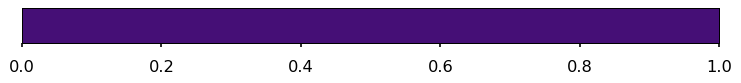

In [954]:
from plot_utils import show_grid, show_products_mean, show_products_box, show_products_violin, show_products_table, show_products_swarm, show_products_strip

possible_q = np.linspace(0, 1, 20)
# make the initial distribution completely uniform
p = np.ones_like(possible_q) / len(possible_q)
q_pmf = {q:p for q, p in zip(possible_q, p)}

            
show_grid(q_pmf)

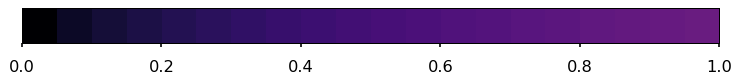

In [955]:
update = {q:lik(q, '👍') for q in q_pmf}
next_pmf = bayes(q_pmf, update)
show_grid(next_pmf)

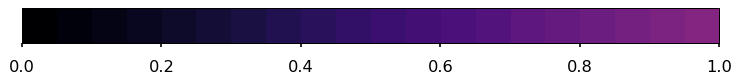

In [956]:
update = {q:lik(q, '👍') for q in q_pmf}
next_pmf = bayes(next_pmf, update)
show_grid(next_pmf)

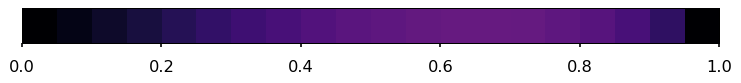

In [957]:
update = {q:lik(q, '👎') for q in q_pmf}
next_pmf = bayes(next_pmf, update)
show_grid(next_pmf)

C:\Users\John\AppData\Local\Temp/ipykernel_26164/2395531436.py:6: RuntimeWarning: divide by zero encountered in log
  return sum(np.log(pmf[outcome]) for outcome in outcomes)


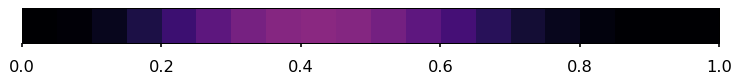

In [974]:
update = {q:np.exp(product_llik(q, '👎👎👎👍👍👎👍👎👍👎👍👎')) for q in q_pmf}
next_pmf = bayes(q_pmf, update)
show_grid(next_pmf)

### Probabilistic filtering and sequential ("recursive") updates

The names *prior* and *posterior* can refer to distinct parts of a modelling process (e.g. I elicit a prior from an expert, then run an experiment to observe data that I use to compute a posterior). But the naming of prior and posterior is *purely relative*! 

It's completely fine for a prior for one step of an inference process to become the posterior for another step. Everything is just probability distributions, which are a universal language -- everything plugs together (over the same sample space, anyway).

<img src="imgs/recursive.png" width="50%">

We saw this above; we just fed in our observations of like or dislike one at a time, and got a new distribution at each step. We *can* feed them all at once, and the result is exactly the same (modulo numerical differences). In cases where data is streaming in over time, it is particularly useful that these recursive updates are easy. This is sometimes called *recursive* updates, or more commonly a *probabilistic filter*. Algorithms like the Kalman filter and particle filters are just ways of implementing this update for continuous (vector) spaces; *exact* in the case of Kalman filters, MCMC in the case of particle filters.


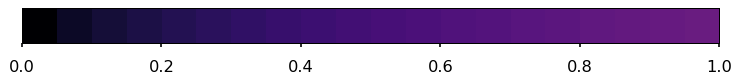

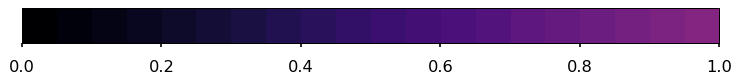

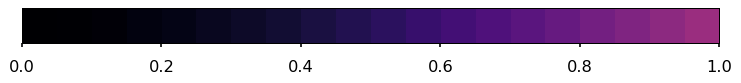

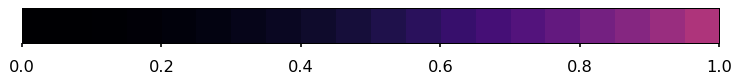

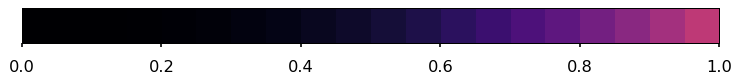

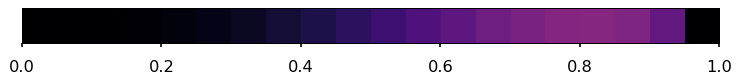

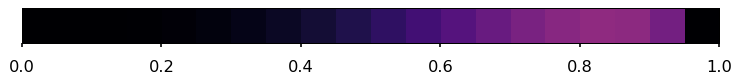

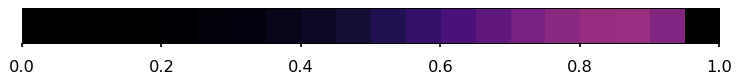

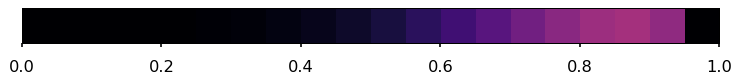

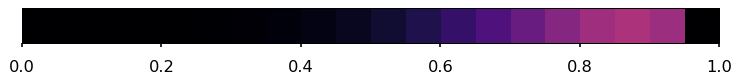

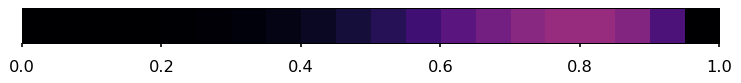

In [976]:
updates = '👍👍👍👍👍👎👍👍👍👍👎'
like_pmf = q_pmf.copy()
for like in updates:
    update = {q:lik(q, like) for q in q_pmf}
    # recursive uodate
    like_pmf = bayes(like_pmf, update)
    show_grid(like_pmf)


C:\Users\John\AppData\Local\Temp/ipykernel_26164/2395531436.py:6: RuntimeWarning: divide by zero encountered in log
  return sum(np.log(pmf[outcome]) for outcome in outcomes)


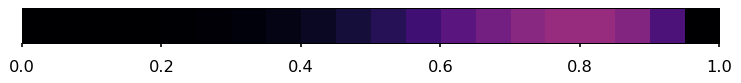

In [978]:
update = {q:np.exp(product_llik(q, updates)) for q in q_pmf}
single_pmf = bayes(q_pmf, update)
show_grid(single_pmf)

### Computing for our dataset
We can just feed in our food like data to this model, computing one distribution for each food in the dataset. Since we have counts, rather than a big string, I'll write a slightly more efficient version of the likelihood:

In [979]:
def count_llik(q, like, dislike): 
    # return the likelihood for a count of likes and dislikes
    return ss.binom.logpmf(like, like+dislike, q)

# again, flat prior
prior = {q:p for q, p in zip(possible_q, p)}

# update each distribution
food_pmfs = {}
for ix, row in foods.iterrows():    
    food_lik = {q:np.exp(count_llik(q, row["like"], row["dislike"])) for q in prior}
    # prior -> posterior
    updated_pmf = bayes(prior, food_lik)
    food_pmfs[row["food"]] = updated_pmf    


In [980]:
print(food_pmfs)

{'chicken': {0.0: 0.0, 0.05263157894736842: 0.0, 0.10526315789473684: 0.0, 0.15789473684210525: 0.0, 0.21052631578947367: 0.0, 0.2631578947368421: 0.0, 0.3157894736842105: 0.0, 0.3684210526315789: 0.0, 0.42105263157894735: 0.0, 0.47368421052631576: 0.0, 0.5263157894736842: 0.0, 0.5789473684210527: 0.0, 0.631578947368421: 0.0, 0.6842105263157894: 0.0, 0.7368421052631579: 0.0, 0.7894736842105263: 1.0750111123503937e-230, 0.8421052631578947: 1.7138766914423628e-91, 0.894736842105263: 0.9999995665991764, 0.9473684210526315: 4.334008236296878e-07, 1.0: 0.0}, 'licorice': {0.0: 0.0, 0.05263157894736842: 5.516156076794195e-12, 0.10526315789473684: 0.0008253749675331235, 0.15789473684210525: 0.3743477296132985, 0.21052631578947367: 0.596392115108984, 0.2631578947368421: 0.028338198066219383, 0.3157894736842105: 9.654761691691067e-05, 0.3684210526315789: 3.462004247667262e-08, 0.42105263157894735: 1.4895271010959608e-12, 0.47368421052631576: 7.426274936144876e-18, 0.5263157894736842: 3.599459789

limit_output extension: Maximum message size of 10000 exceeded with 13423 characters

In [3]:
# sort, to make the visualisations we see clearer
food_pmfs = sorted(food_pmfs, expectation(food_pmfs))

NameError: name 'food_pmfs' is not defined

### Reporting results
We can report our results in various ways. For each product, we have a PMF. We could show this as Box plots, violin plots, gradient strips. What we should *not* do is just show the mean (or max or min)!

#### A table of quantiles
We can bound the parameter distribution at quantiles (i.e. divisions of the probability mass). A common set of quantiles are the quartiles, even divisions into four parts. Reporting as a table is precise but a poor visualisation.

In [2]:
show_products_table(food_pmfs)

NameError: name 'show_products_table' is not defined

C:\local\anaconda3\envs\pymc3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\local\anaconda3\envs\pymc3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\local\anaconda3\envs\pymc3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\local\anaconda3\envs\pymc3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\local\anaconda3\envs\pymc3\lib\site-packages\seaborn\categorical.py:1296: UserWarnin

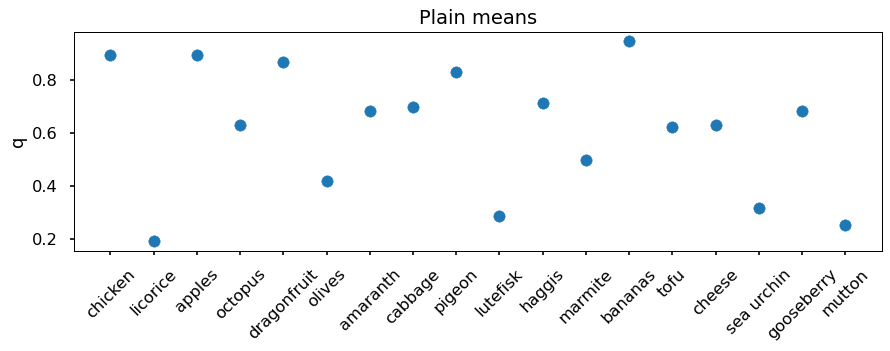

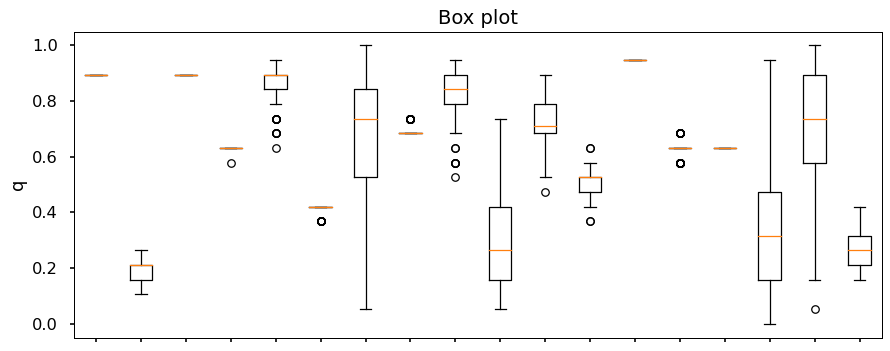

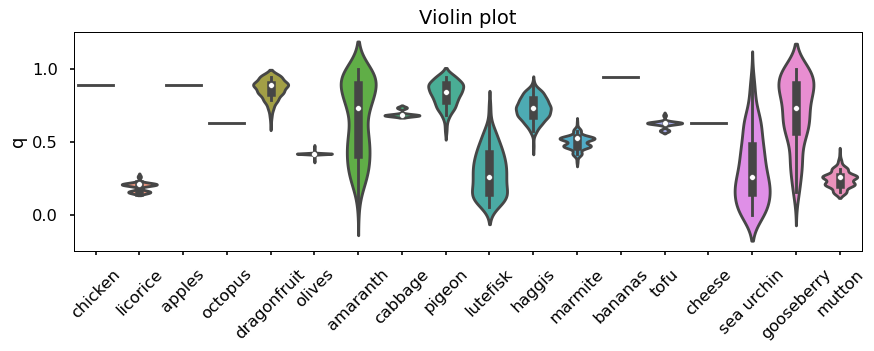

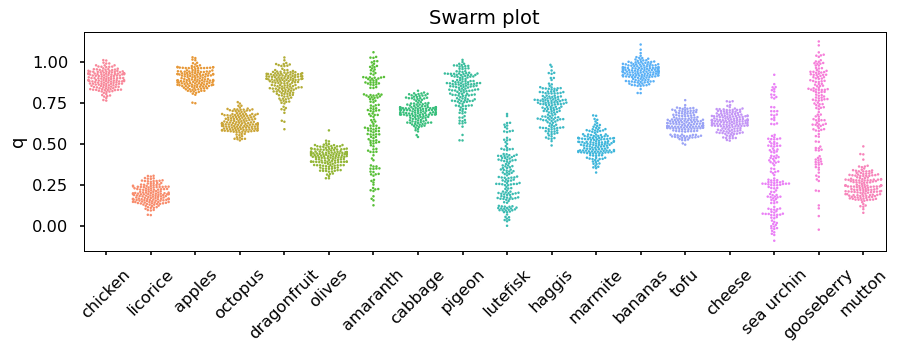

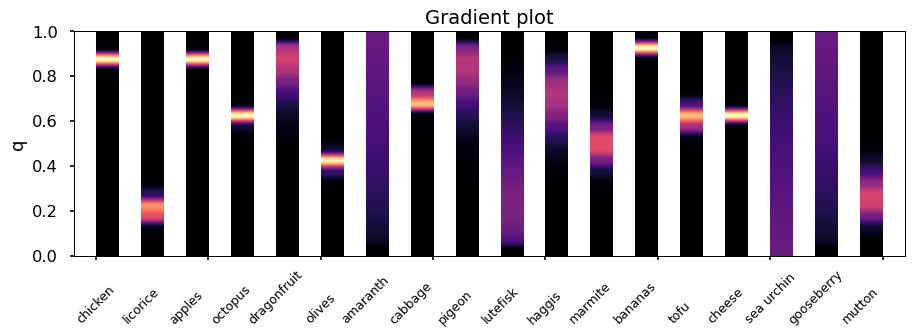

In [982]:
show_products_mean(food_pmfs)
show_products_box(food_pmfs)
show_products_violin(food_pmfs)
show_products_swarm(food_pmfs)
show_products_strip(food_pmfs)

## Expectation
If we wanted to rank the choices, we need a single numerical measure. We can obtain one via expectation. Because we preserved the whole distribution, we can select different "lenses" on the distribution by selecting different functions to apply to the outcomes, not just the mean.

### The picky dinner guests
Imagine we have different kinds of dinner party guests:
* standard
* cautious
* relaxed
* rigidly picky
* controversial
* weird food lover

How would we rank foods to prepare under those assumptions? We'd value different $q$ values differently in each case.

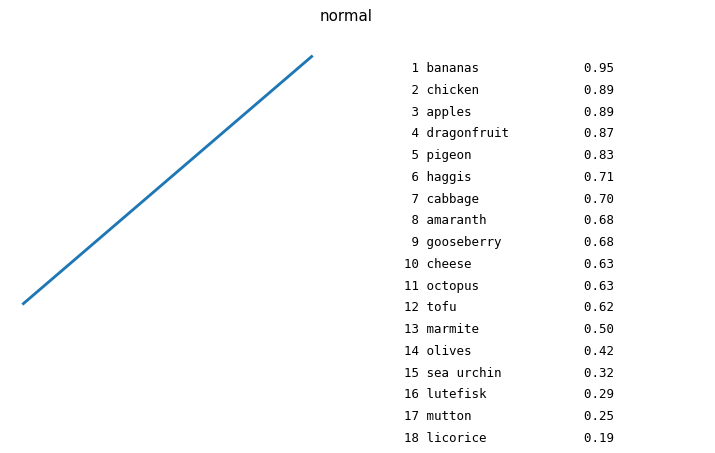

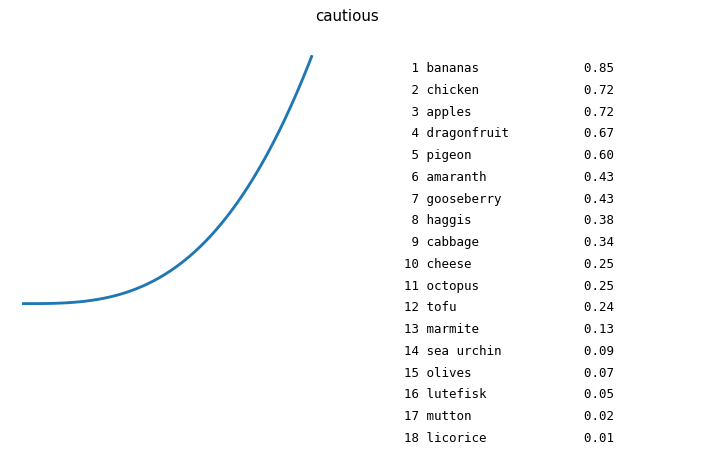

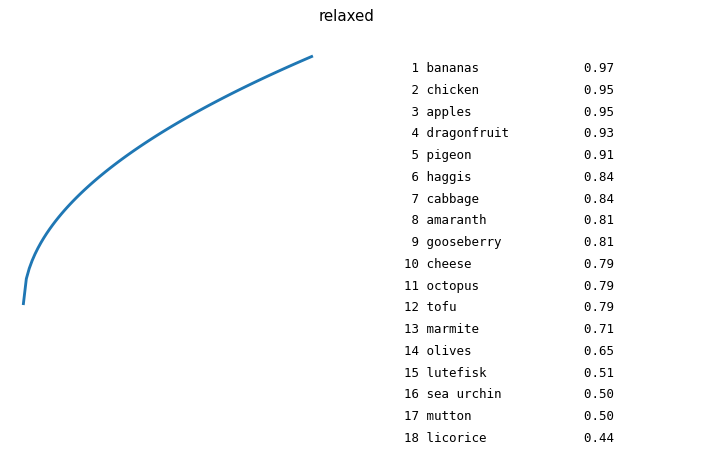

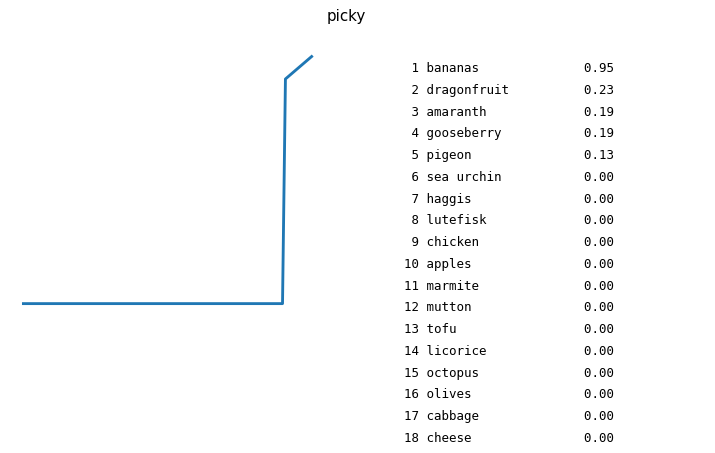

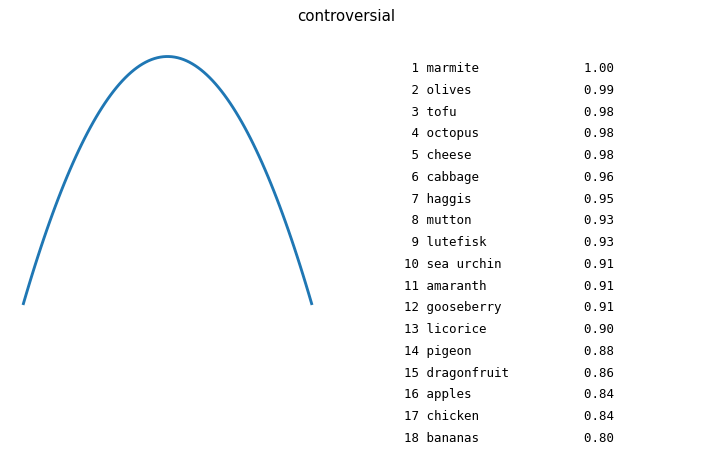

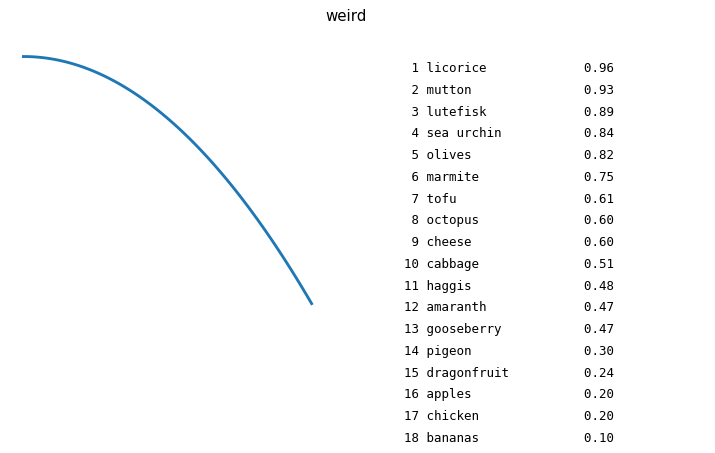

In [986]:
def rank_products(pmfs, fn):    
    expected = [(name, expectation(pmf, fn)) for name, pmf in pmfs.items()]
    return sorted(expected, key=lambda x:-x[1])

def show_ranks(pmfs, fn, eater_name=''):
    fig, ax = plt.subplots(ncols=2)
    xs = np.linspace(0,1, 100)
    ax[0].plot(xs, [fn(x) for x in xs])
    ranks = rank_products(pmfs, fn)
    y = 0.9
    ax[0].axis("off")
    for i, (name, score) in enumerate(ranks):
        ax[1].text(0, y, f"{i+1:4d} {name:20s} {score:3.2f}", family="monospace")
        y -= 0.08
    ax[1].set_ylim(0, 1)
    ax[1].axis("off")
    fig.suptitle(eater_name)
    
        
# mean rank        
show_ranks(food_pmfs, lambda x:x, 'normal')
# pessimistic
show_ranks(food_pmfs, lambda x:x**3, 'cautious')
# optimistic
show_ranks(food_pmfs, lambda x:x**0.5, 'relaxed')
# only if we're sure it's 90% good
show_ranks(food_pmfs, lambda x:0 if x<0.90 else x, 'picky')
# only controversial
show_ranks(food_pmfs, lambda x:1-(x-0.5)**2, 'controversial')
# backwards
show_ranks(food_pmfs, lambda x:1-x**2, 'weird')
    

### Entropy
The **entropy** of the posterior distribution tells us the uncertainty or "how much is left to learn". We can plot this as a way of identifying foods we should perhaps gather more data about.

Text(81.375, 0.5, 'Entropy (bits)')

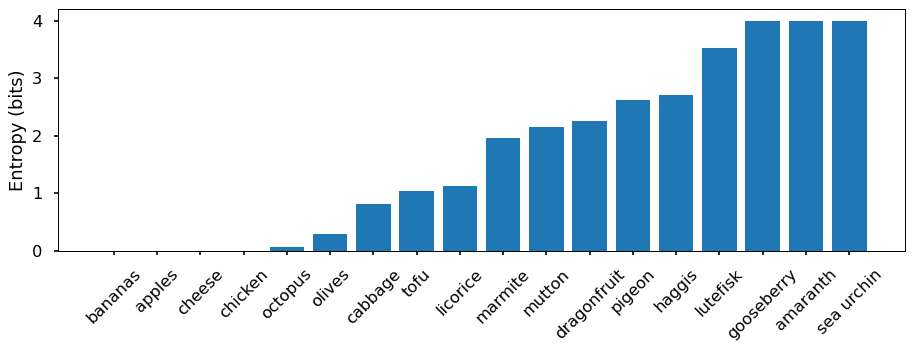

In [968]:
fig, ax = plt.subplots()

def entropy(pmf):
    return -sum(0 if p==0 else p * np.log2(p) for p in pmf.values())

entropies = np.array([entropy(pmf) for pmf in food_pmfs.values()])
entropy_order = np.argsort(entropies)
ax.bar(np.arange(len(food_pmfs)), entropies[entropy_order] , tick_label=np.array(list(food_pmfs.keys()))[entropy_order])
rotate_labels()
ax.set_ylabel("Entropy (bits)")

### Alternative priors
One of the advantages of a Bayesian approach is that we can introduce *informative* priors.
Can we incorporate prior information here? Yes, we can -- we might know that people generally like fruits. We can assign a more
optimistic prior (more likely to have a high `q`) to the fruit items.

C:\Users\John\AppData\Local\Temp/ipykernel_26164/2395531436.py:6: RuntimeWarning: divide by zero encountered in log
  return sum(np.log(pmf[outcome]) for outcome in outcomes)


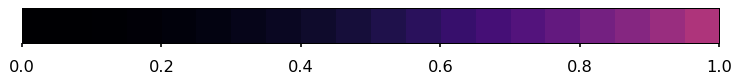

In [987]:
# flat prior
prior = {q:p for q, p in zip(possible_q, p)}

# fruit has some prior likelihood of being good
fruit_prior = bayes(prior, {q:np.exp(product_llik(q, '👍👍👍👍')) for q in prior})

show_grid(fruit_prior)

C:\Users\John\Dropbox\research_teaching\cix_2022\plot_utils.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.tight_layout()


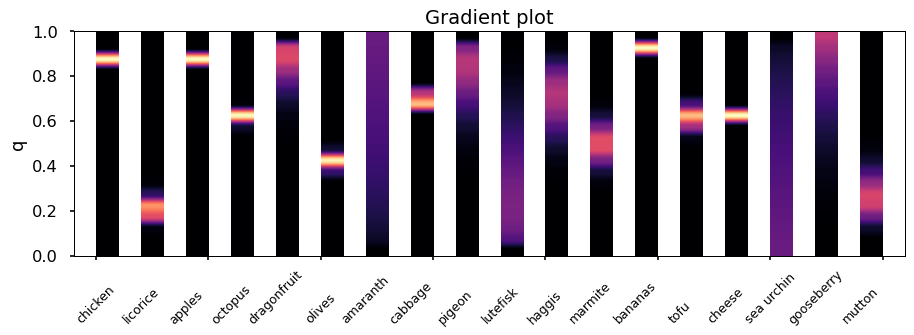

In [988]:
# update each distribution
food_pmfs = {}
for ix, row in foods.iterrows():
    
    food_lik = {q:np.exp(count_llik(q, row["like"], row["dislike"])) for q in prior}
    # select the prior based on the fruit column
    if not row["fruit"]:
        updated_pmf = bayes(prior, food_lik)
    else:
        updated_pmf = bayes(fruit_prior, food_lik)
    food_pmfs[row["food"]] = updated_pmf
        

show_products_strip(food_pmfs)
    

### Sensor fusion!!!

One of the major advantages of the Bayesian approach is that we model forwards. This makes it trivial to perform **sensor fusion**, the combination of evidence from multiple sources (e.g. from an IMU and a GPS in a vehicle tracking system). We just include the extra channel of information into our Bayesian update. 


Imagine we believed the "quality" of a product depended not only on the like/disklike distribution, but also on the number of exclamation marks in the product title. How could we introduce this information? Simple: write down a likelihood, telling us how likely $n$ question marks are given a $q$ and include it as the prior. It's just the same as how we incorporated the `fruit` indicator earlier.

In [989]:
# This is a generative model!
def exclamation_sample(title, q):
    return title + ss.poisson(q*4).rvs() * '!'

def exclamation_lik(title, q):
    return ss.poisson(q*4).pmf(title.count("!"))

C:\Users\John\AppData\Local\Temp/ipykernel_26164/2395531436.py:6: RuntimeWarning: divide by zero encountered in log
  return sum(np.log(pmf[outcome]) for outcome in outcomes)


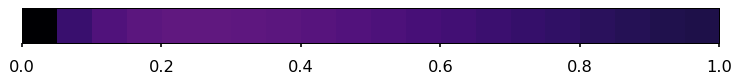

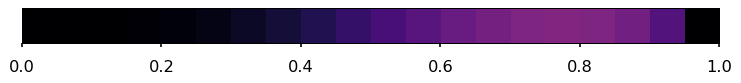

In [992]:
# likelihood of observing this number of exclamation marks
name = "apples!"
exc_prior = {q:exclamation_lik(name, q) for q in q_pmf}
exc_pmf = bayes(q_pmf, exc_prior)
show_grid(exc_pmf)

# and then introduce some like/dislike data
like_lik = {q:np.exp(product_llik(q, "👍👍👎👍👍👍👍")) for q in q_pmf}
like_post = bayes(exc_pmf, like_lik)

show_grid(like_post)

This is a generative model. So if we know how good something is, we can predict how many exclamation marks it ought to have in its listing:

In [1002]:
print(exclamation_sample("apples", 0.9))
print(exclamation_sample("olives", 0.1))

apples!!!!
olives


#### Why fusion is easy in a Bayesian world
Why did this work so easily? Because our model described what observations we would see under a given hypothesis, and *not* what hypothesis we would see under a given observation. This difference is critical: fusion is trivial with a forward model + Bayesian inference, but challenging to do with a direct inverse model.

## Shadow worlds: latent and predictive

![Shadow world](imgs/shadow_world.png)

### (Prior, posterior) x (parameter, predictive)

It's important to keep the various elements of a Bayesian model distinct.

#### Over parameters (inference)
* **Prior** a distribution over unknown parameters before some observations
* **Posterior** a distribution over unknown parameters after observations

#### Over observations (simulation)
* **Prior predictive** a distribution over observations *that our model would generate* under the priors.
* **Posterior predictive** a distribution over observations *that our model would generate* under the posterior.


#### Example
Let's show an example, for the posterior over licorice:

[Text(0.25, 0, '+'), Text(0.75, 0, '-')]

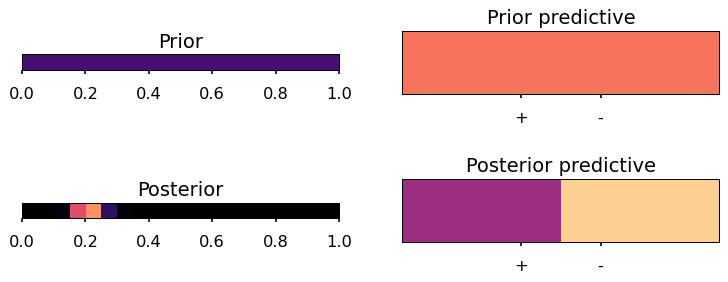

In [1003]:

lic_pmf = food_pmfs["licorice"]

fig, axs = plt.subplots(nrows=2, ncols=2)
show_grid(prior, axs[0,0]) 
show_grid(lic_pmf, axs[1,0]) 
axs[0,0].set_title("Prior")
axs[1,0].set_title("Posterior")

prior_predictive = {'👍':expectation(prior), '👎':1-expectation(prior)}
show_grid(prior_predictive, axs[0,1])
axs[0,1].set_title("Prior predictive")
axs[0,1].set_xticks([0.25, 0.75])
axs[0,1].set_xticklabels("+-")

posterior_predictive = {'👍':expectation(lic_pmf), '👎':1-expectation(lic_pmf)}
show_grid(posterior_predictive, axs[1,1])
axs[1,1].set_title("Posterior predictive")
axs[1,1].set_xticks([0.25, 0.75])
axs[1,1].set_xticklabels("+-")

In [1004]:
sample(lic_pmf, 10) # posterior samples

[0.2631578947368421,
 0.21052631578947367,
 0.15789473684210525,
 0.21052631578947367,
 0.21052631578947367,
 0.15789473684210525,
 0.15789473684210525,
 0.15789473684210525,
 0.21052631578947367,
 0.15789473684210525]

In [1005]:
sample(posterior_predictive, 10) # posterior predictive samples

['👍', '👎', '👎', '👎', '👎', '👎', '👎', '👎', '👎', '👎']


## Bayesian modelling and inference process
<img src="imgs/bayesian_flow.drawio.png">

### The process of eliciting, encoding and validating
What does it look like to *do* Bayesian modelling? We need to do several things:

* Elicit models (data generating processes) that we believe are good fits to the phenomena we expect;
* Encode our beliefs about plausible configurations of those models mathematically, as prior distributions on parameters.
* Infer posterior distributions over those parameters using an inference algorithm.
* Validate that our modelling assumptions held true.
* Report the results

#### Elicit and encode

* We need to write down the **data generating process**. 
    * This usually means we have a model that can both *sample* (simulate) 
    * and can be fed observations to return likelihoods. 
    * This model may have arbitrary internal structure, and might often have a hierarchical arrangement. 
* The **parameters** need to be identified, and ideally scaled/chosen such that they are *interpretable*.
* We need to set **priors** for the parameters. This would typically be guided by existing data, expert opinions or other sources
    * People often fret about setting priors, but the point is that it rarely matters greatly -- just encode what you know! If that turns out to be not very much, the model will still work just fine.
    
#### Infer
* We then need to apply an inference algorithm to update the probability distribution over parameters.
* This typically involves an approximate iterative algorithm
* The output is a representation of the **posterior** distribution over model parameters
* This will often be *samples* from the posterior distribution (if using MCMC, as described below)

#### Validate
* We must validate that our modelling choices are reasonable and that our DGP behaves as it ought. For example, we might check:
    * That the prior predictive distributions simulates data that looks like it is compatible with our prior beliefs
    * That the posterior predictive distribution looks like the observed data
    * That fitting the model on the posterior predictive estimates the same parameters as the observations
    * Diagnostic information from our inference algorithm:
        * For example, MCMC algorithms can fail in various in ways, and there are measures that help detect some of the common failure modes

#### Report
* We need to report the results. This typically involves summarising the posterior distribution
* Histograms, Box plots, tables, interactive visualisations can all be used to do so


## Concrete algorithms for inference
In general, we wouldn't use the grid type models we used for the `food` problem for real-world problems.

* **Q: Why not?** [POLL]

Practical algorithms for problems that involve *continuous* variables fall into three basic types. We'll see each type applied to the like/dislike problem.

---


### Exact
Very occasionally, we can compute the exact density function for a posterior distribution by some algebraic trickery. This is only possible if our prior and likelihood have a very specific form. Lots of classic Bayesian texts rely heavily on exact methods, but they are rarely useful in practice except in a few niches.

#### Data structure
* Parameter vectors (associated with density functions)

#### Algorithm

Direct computation.

* We have a **parametric** form for our prior density $f_X(\theta)$ (e.g. a normal distribution with parameters $\mu$ and $\sigma^2$).
* We have a collection of observations
* We have a **parametric** likelihood function that is compatible with our prior density function; $L(x|\phi)$
* We run a computation that computes closed-form a **parametric** density function for the posterior $g(\psi)$.

$f$, $L$ and $g$ don't have to have the same form (e.g. they might not all be normal), but they do have to be compatible ("conjugate priors"). 


#### Pros and cons

* Advantages: Extremely efficient; no approximation error.
* Disadvantages: constrains you to a small range of modelling choices; requires special implementation for each case; can be complicated to understand.

#### Exact like/dislike
If we *assume* that we can model the like/dislike distribution with a *beta* distribution (just a distribution over values from 0 to 1), then we can directly perform a Bayesian update.

The distribution has two parameters $a, b$ and there is a simple algorithm that, given a count of likes and dislikes, returns a new $a, b$ for the updated distribution. This can only ever model distributions
that have the beta "shape"; but this isn't that limiting in this simple example.

In [1006]:
a, b = 1,1
# takes a,b and a like sequence
# and returns an *exact* a and b for a Bayesian update

def beta_update(a, b, likes):
    k = sum([s=='👍'  for s in likes])
    n = len(likes)
    return a + k, b + n - k



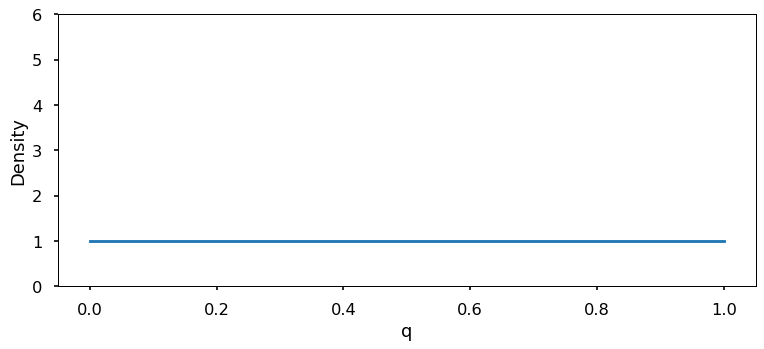

In [1007]:
def show_beta(a, b):
    xs = np.linspace(0, 1, 512)    
    beta_pdf = ss.beta(a, b).pdf(xs)
    fig, ax = plt.subplots()
    ax.plot(xs, beta_pdf)
    ax.set_ylim(0,6)    
    ax.set_ylabel("Density")
    ax.set_xlabel("q")
    
a, b = 1,1
show_beta(a,b)

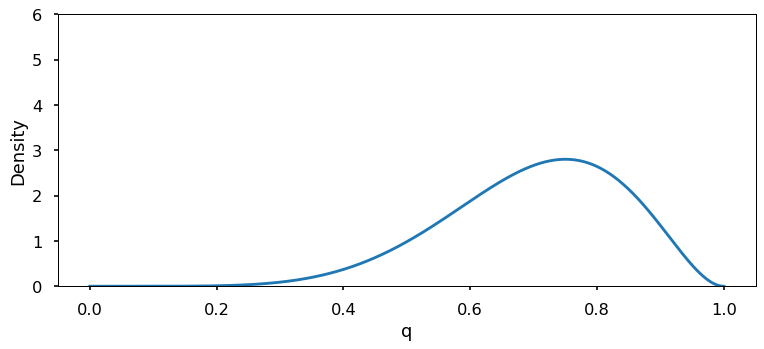

In [1008]:
a, b = beta_update(a, b, '👍👍👎👍👍👎👍👍')
show_beta(a,b)

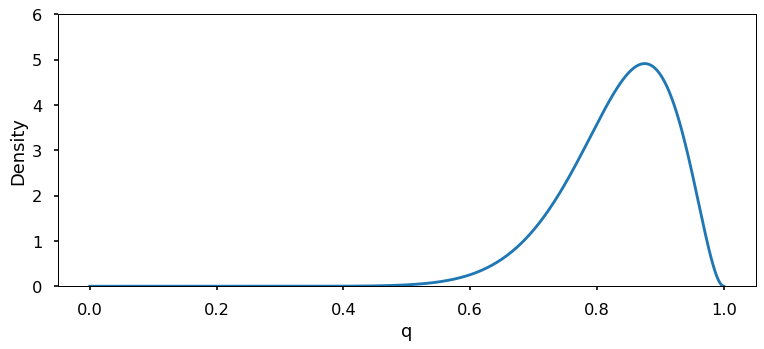

In [1009]:
a, b = beta_update(a, b, '👍👍👍👍👍👍👍👍')
show_beta(a,b)

---



### MCMC
MCMC (or Markov Chain Monte Carlo) is an approximation method that represents all distributions via collections of samples drawn from them. This makes it easy to apply arbitrary functions (just apply the function to each sample), but requires carefully designed algorithms to do Bayesian updates. 

In a Bayesian context, an MCMC sampler is used to draw samples from the posterior distribution.

#### Data structure
* Samples (i.e. sequences of values in the sample space *of parameters*)

#### Algorithm

Stochastic process, which gradually approximates the posterior. A true MCMC process makes small random steps in posterior space, and filters out or otherwise adjusts these random walks such that the samples tend to the posterior distribution.

Common algorithms include Gibbs sampling (fast but limited); Metropolis-Hastings (general, but inefficient); Hamiltonian (fairly fast; requires derivatives).

#### Pros and cons
* Advantages: extremely general ("one button inference"); samples are easy to work with (just arrays of definite numbers); lots of sophisticated algorithms
* Disadvantages: may not converge; lots of tuning and tweaking to get sampling to work; some problems are very resistant to sampling based solutions (e.g. exotic geometry, partially discrete problems)

#### MCMC like/dislike


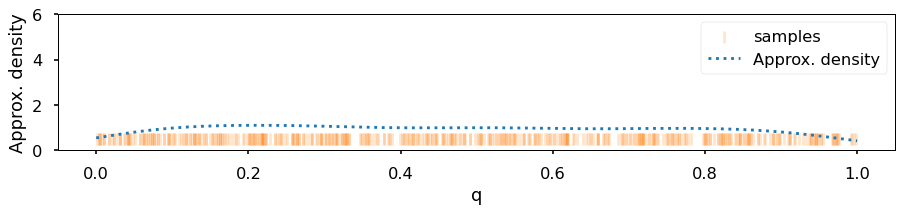

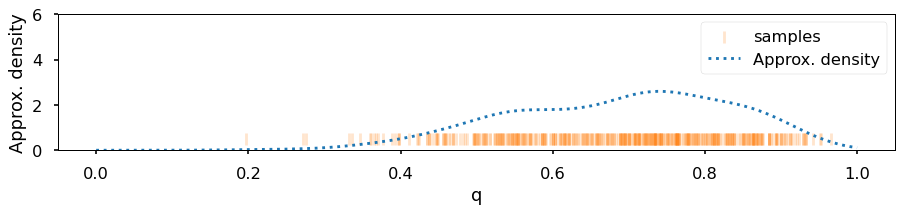

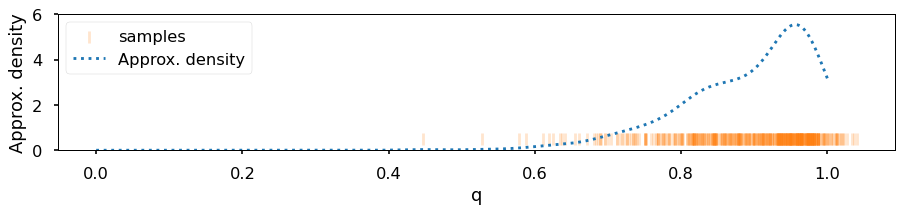

In [1010]:
n_samples = 500
samples = np.random.uniform(0, 1, n_samples) # uniform prior

def importance_sample(samples, likes):    
    # update samples based on likelihood
    weights = np.array([np.exp(product_llik(samp, likes)) for samp in samples])
    weights = weights / np.sum(weights)
    # reproduce samples that are more highly weighted
    resampled = np.random.choice(samples, size=samples.shape, p=weights)
    resampled += np.random.normal(0, 0.02, resampled.shape)
    return resampled

def plot_samples(samples):
    fig, ax = plt.subplots(figsize=(12,2))
    xs = np.linspace(0, 1, 512)
    ax.scatter(samples, samples*0+0.5, marker='|', c='C1', alpha=0.2, label="samples")
    ax.set_ylim(0,6)
    kde = ss.gaussian_kde(samples)
    ax.plot(xs, kde(xs), ls=':',label="Approx. density")
    ax.legend()
    ax.set_xlabel("q")
    ax.set_ylabel("Approx. density")
    
    
plot_samples(samples)
updated = importance_sample(samples,  '👍👍👎👍👍👎👍👍')
plot_samples(updated)
updated = importance_sample(samples,  '👍👍👍👍👍👍👍👍')
plot_samples(updated)

### Variational
Variational methods are somewhat like exact methods in that they involve manipulating the parameters of a density function algorithmically. But instead of being exact, we use density functions that are known to be computationally easy to apply, and we *optimise* the easy distribution to fit the (hard) posterior distribution.

That is, we find some distribution $Q(X)$ and try and optimise it such that it fits the posterior distribution. We then have a parametric form for $Q$ that is easy to work with, but not one that exactly matches the true posterior shape. 

##### Data structure
* Parameter vector (for a specially chosen class of functions)

##### Algorithm

Optimisation: there are various different strategies. Techniques like automatic differentiation variational inference (ADVI) are a fairly general way to apply variational inference to arbitrary problems, but are limited in the kinds of distribution that can be represented.

#### Pros and cons
* Advantages: Often very fast, especially compared to MCMC; covers the whole sample space instantly.
* Disadvantages: Requires specific derivation for a given problem (though may be able to use automatic differentiation to help); may have consistent error that will never be resolved by additional computation




## What is a Bayesian [IV]

* Implements data generating processes as computational simulators of expected phenomena, and can simulate concrete implications of hypotheses.
* Applies algorithms such as MCMC or variational inference to infer probability distributions over hidden states (latent variables) from observed data.
* Reports and summarises inferences via approximations that are computationally tractable (e.g. via random samples)
* Is typically concerned with *expectations* of a score function applied to a distribution, such as utility, or controversiality (as in the fruit example).
* Freely fuses evidence from any source, in the past, present or future.


### Why is this Computational HCI?

* We build **statistical models** of user behaviour, and estimate parameters of that model from quantitative observations of data.
* This is a **model-led approach** which has a strong mathematical underpinning and many powerful algorithms which can be brought to bear.
* This is **robust** (it appropriately represents uncertainty) and **generative** (it can simulate behaviour compatible with observations).  

**[Part III: Bayesian HCI](iii_bayesian_hci.ipynb)**